In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col

In [2]:
WORK_DIRECTORY = "data"
DATA_FILE_NAME = "leukemia_met_trans"
DATA_FEATURES = "leukemia_met_features"
INFO_FILE = "sample_cancer.txt"

In [ ]:
# create spark session
spark = (
    SparkSession.builder.master("local")
    .appName("Colab")
    .config("spark.driver.memory", "32g")
    .config("spark.executor.cores", "1")
    .config("spark.cores.max", "1")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "100g")
    .getOrCreate()
)

spark.conf.set("spark.sql.pivotMaxValues", 500000)

In [4]:
# create spark dataframe
df = spark.read.option("maxColumns", 200000).csv(
    os.path.join(WORK_DIRECTORY, DATA_FILE_NAME),
    header=True,
    sep=";",
)

In [5]:
# information about sample types and tissues
info = pd.read_csv(os.path.join(WORK_DIRECTORY, INFO_FILE), sep=" ")
info = info[["sample_id", "sample_type", "tissue"]]
info["sample_id"] = info["sample_id"].apply(lambda p: p.replace("-", ""))
info = spark.createDataFrame(info)

/tmp/ipykernel_340536/2358533232.py:2: DtypeWarning: Columns (4,5,12,13,14,24,29,36,37,38,42,50,51,62,64,66) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv(os.path.join(WORK_DIRECTORY, INFO_FILE), sep=' ')
/home/maria/.local/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/maria/.local/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [6]:
columns = df.columns
# columns = columns[:100]

In [7]:
# df = df.limit(10)
# df = df.select(columns)

In [8]:
class DimReductionPCA:
    """
    Class transform data {index:methylation_site, col:sample_id}
            to data {index:sample_id, cols:methylation_site}.

    Methods:
    1. data_to_float: change data types to float and add 0.001
        to each element to avoid sparse vectors
    2. feature_vectors: convert input data to feature vectors.
    3. pca_model: make and train pca model.
    4. pca_transform: transform data to pca outs.
    5. add_info: merge information about sample and tissue types.
        Make separated columns for first and second components.
    6. scatter_2D: show scatter plot for different sample and tissue types.
    7. hist_plot: show historgam for different sample and tissue types.


    """

    def __init__(self, data, columns):
        self.data = data
        self.columns = columns

    def data_to_float(self):
        self.data = self.data.select(
            *(
                (col(c).cast("float") + 0.001).alias(c)
                if c != "s" else col(c).alias(c)
                for c in self.columns
            )
        )

    def feature_vectors(self):
        assembler = VectorAssembler(inputCols=self.columns[1:],
                                    outputCol="features")
        self.data = assembler.transform(self.data)
        self.data = self.data.select(["s", "features"])

    def pca_model(self):
        pca = PCA(k=2, inputCol="features", outputCol="pca")
        self.pca_model = pca.fit(self.data)

    def pca_transform(self):
        self.pca_transformed = self.pca_model.transform(self.data)
        self.pca_transformed = self.pca_transformed.select(["s", "pca"])

    def add_info(self, info):
        self.pca_transformed = self.pca_transformed.join(
            info, self.pca_transformed.s == info.sample_id, "inner"
        )
        self.pca_transformed = self.pca_transformed.toPandas()
        self.pca_transformed["reduce_1"] = self.pca_transformed["pca"].apply(
            lambda p: p[0]
        )
        self.pca_transformed["reduce_2"] = self.pca_transformed["pca"].apply(
            lambda p: p[1]
        )

    def scatter_2D(self, data, title):
        plt.figure(figsize=(7, 7))
        sp = sns.scatterplot(
            data=data, x="reduce_1", y="reduce_2",
            hue="sample_type", style="tissue"
        )
        sp.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=1)
        plt.grid()
        plt.title(title)

    def hist_plot(self, data, title):
        plt.figure(figsize=(7, 7))
        sp = sns.histplot(
            data=data, x="tissue", hue="sample_type",
            multiple="dodge", shrink=0.8
        )
        sp.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=1)
        plt.xticks(rotation=90)
        plt.grid()
        plt.title(title)

In [9]:
# data preparation
pca_red = DimReductionPCA(df, columns)
pca_red.data_to_float()
pca_red.feature_vectors()

In [ ]:
# train pca model
pca_red.pca_model()

In [ ]:
# transformed data
pca_red.pca_transform()
pca_red.add_info(info)
pca_transformed = pca_red.pca_transformed

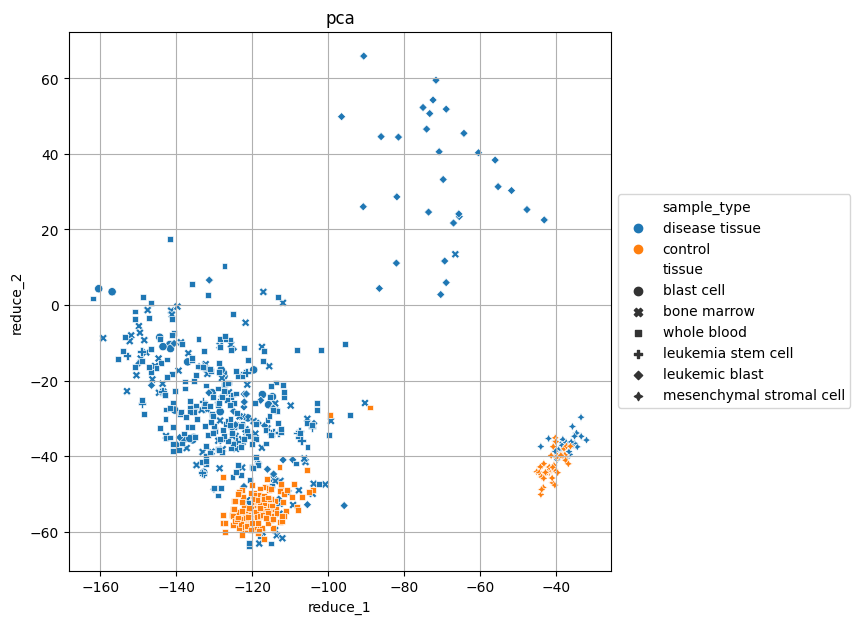

In [15]:
# pca plot
pca_red.scatter_2D(pca_transformed, "pca")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


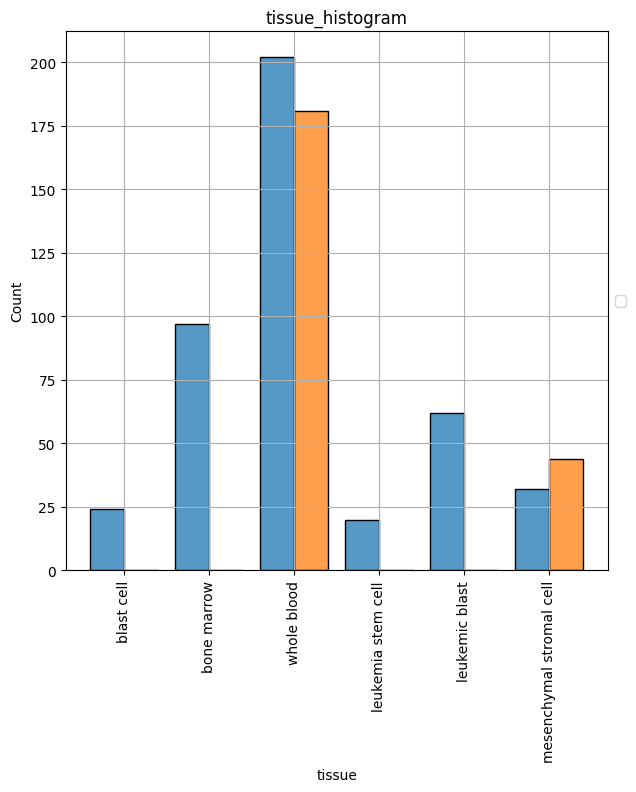

In [16]:
# historgam for different sample and tissue types.
pca_red.hist_plot(pca_transformed, "tissue_histogram")

In [17]:
pd.unique(pca_transformed["tissue"])

array(['blast cell', 'bone marrow', 'whole blood', 'leukemia stem cell',
       'leukemic blast', 'mesenchymal stromal cell'], dtype=object)

In [18]:
# samples only for tissue with control and disease types
pca_transformed_t = pca_transformed[
    (pca_transformed["tissue"] == "whole blood")
    | (pca_transformed["tissue"] == "mesenchymal stromal cell")
]

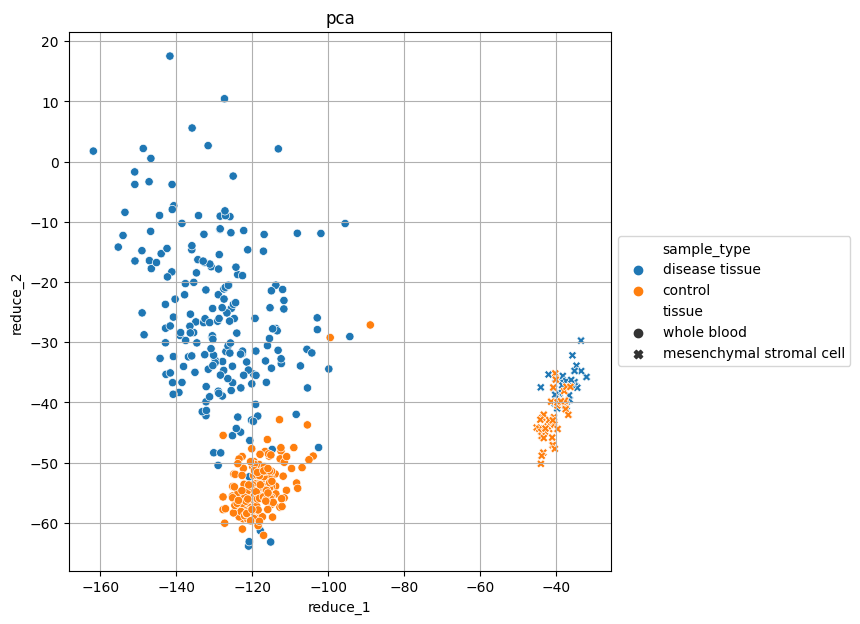

In [19]:
# pca plot
pca_red.scatter_2D(pca_transformed_t, "pca")

In [20]:
# samples only for disease tissue
pca_transformed_d = pca_transformed[
    (pca_transformed["sample_type"] == "disease tissue")
]

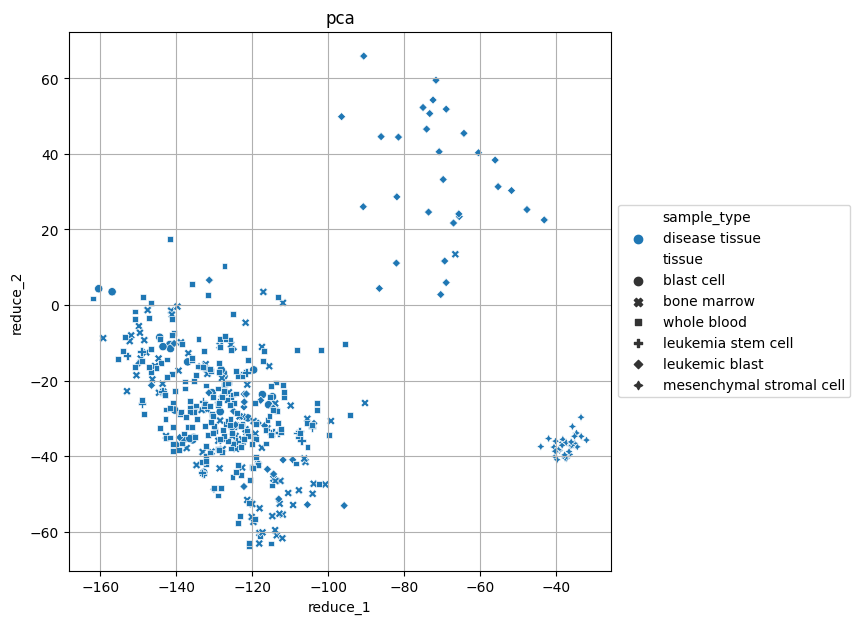

In [21]:
# pca plot
pca_red.scatter_2D(pca_transformed_d, "pca")